# Implementación y agregación de segmentadores
## 1. Integrantes del grupo
Este trabajo pertenece al Grupo 18 - Equipo 3. Los integrantes somos:
- Irene Fanjul i Penella
- Miguel Jiménez Gomis
- Carles Serra Vendrell
- Adrián Bañuls Arias
- Miriam Pardo Cuesta 

Enlace a Google Colaboratory: https://colab.research.google.com/drive/1I7sQRmyx9-ks8E7igUie067lKDGkNXow?usp=sharing#scrollTo=GCFdKnFBXbUV
## 2. Organización de las reuniones
| Reuniones | Descripción |
|------------|:-----------------------------------------------------------------------------------------------------------------------:|
| 14/02/2021 | Planificación de las tareas a realizar. Elección del segmentador a desarrollar. |
| 18/02/2021 | Puesta en común de las soluciones investigadas de forma independiente por cada integrante y de las dudas surgidas. | 
| 23/02/2021 | Corrección de bugs y análisis de los resultados. | 
| 24/02/2021 | Redacción final de la entrega y limpieza del notebook.| 

Todos los integrantes del grupo han participado en todas las reuniones.

## 3. Descripción del problema
Como problema a tratar en este trabajo se ha seleccionado la detección de barcos en imágenes satélite. 
Se han escogido un subset de imágenes del Dataset de la competición de Kaggle de Airbus [2], la cual incluye el Ground truth de las imágenes para poder evaluar los resultados obtenidos.
## 4. Solución propuesta
Se han implementado 3 segmentadores de imágenes que generan máscaras binarias indicando las posiciones en las que puede haber un barco.
Así mismo, se ha implementado un cuarto segmentador que combina las salidas de los 3 anteriormente mencionados agregando sus resultados y codificando un método de selección en caso de empate.

Se importan las librerías necesarias y se cargan los datos de prueba. Por falta de espacio no se muestran en este documento, se pueden ver en el Notebook entregado o en el enlace de Google Colab proporcionado

# Importación de librerías

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage import io, morphology
from skimage.morphology import opening, closing, disk

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker, slic, felzenszwalb
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import sobel
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import pandas as pd
import skimage.color as color
# Paquetes necesarios para la morfología matemática
from skimage.morphology import erosion, dilation

In [ ]:
!rm *.*
!git clone https://github.com/Miriam-Pardo/PC.git
!mv PC/"Airbus Ships"/* /content/
!rm -rf PC

# Programación de los segmentadores

Antes de programar los Segmentadores se definen las variables comunes y el métodod de evaluación de estos segmentadores para ello primero se genera la función que decodifica el ground truth del dataset.

In [ ]:
# Decodificación del ground truth
def decodeGroundTruth(encoded_pixel, img_size, archive_name):
    encoded_pixel[0].split(' ')
    rle = list(map(int, encoded_pixel[0].split(' ')))
    pixel,pixel_count = [],[]
    [pixel.append(rle[i]) if i%2==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
    rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
    rle_mask_pixels = sum(rle_pixels,[]) 
    mask_img = np.zeros((img_size[0]*img_size[1],1), dtype=int)
    mask_img[rle_mask_pixels] = 255
    l,b=cv2.imread(archive_name).shape[0], cv2.imread(archive_name).shape[1]
    mask = np.reshape(mask_img, (b, l)).T
    #plt.imshow(mask, cmap='gray')
    return mask/255

Una vez se tiene esta función para generar la máscara del ground truth, se procede a desarrollar una función para evaluar los segmentadores.
Esta funcion tiene 2 partes:


*   Unbucle que itera por todas las imágenes del conjunto de test y calcula su máscara del segmentador y decodifica su ground truth.
*   Una función que dada la máscara y el ground truth calcula la matriz de confusión para cada imagen.

Por ultimo los resultados se agregan y se muestra el promedio de la matriz de confusión.



In [ ]:
def calculate_conf_matrix(mask, ground_Truth):
  '''Esta función calcula los datos de la matriz de confusión para una máscara 
  generada por un segmentador y su ground truth.
  '''
  height, width = mask.shape
  tp, fp, tn, fn = 0, 0, 0, 0
  for i in range(height):
      for j in range(width):
          if (int(mask[i,j] > 0) and (ground_Truth[i,j] > 0)):
              tp += 1
          elif (int(mask[i,j] > 0) and  (ground_Truth[i,j] == 0)):
              fp += 1
          elif (int(mask[i,j] == 0) and  (ground_Truth[i,j] == 0)):
              tn += 1
          elif (int(mask[i,j] == 0) and  (ground_Truth[i,j] > 0)):
              fn += 1              
  return tp, fp, tn, fn

def test_segmentator(segmentator):
  ''' Esta funcion itera por todas las imágenes y calcula el promedio de sus matrices de confusión 
  y muestra las métricas relevantes para un segmentador pasado como parámetro
  '''
  ground_Truth_Data = pd.read_csv("groundtruth.csv") #Se cargan los datos
  tp, fp, tn, fn, esp, acc, rec = [], [], [], [], [], [], []
  n = 0
  for row in ground_Truth_Data.iterrows(): 
    imageName = row[1][0]
    img_ = io.imread(imageName)
    GT = decodeGroundTruth([row[1][1]], img_.shape, imageName) # Se decodifica el Ground truth
    mask = segmentator(img_) #Se obtiene la máscara
    result = calculate_conf_matrix(mask, GT)
    debug = False
    if debug:
      fig, (ax1,ax2,ax3) = plt.subplots(1,3);      fig.set_size_inches(10,10)
      ax1.imshow(img_);      ax1.set_title("Imagen Original")
      ax1.axis('off');      ax2.imshow(GT, cmap='gray')
      ax2.set_title("Ground Truth");      ax2.axis('off')
      ax3.imshow(mask, cmap='gray');      ax3.set_title('Segementador')
      ax3.axis('off');      plt.show();
    tp.append(result[0]);    fp.append(result[1])
    tn.append(result[2]);    fn.append(result[3])    
    esp.append(tn[n]/(tn[n]+fp[n])) if tn[n] + fp[n] != 0 else esp.append(0.00)  
    acc.append(tp[n]/(tp[n]+fp[n])) if tp[n] + fp[n] != 0 else acc.append(0.00) 
    rec.append(tp[n]/(tp[n]+fn[n])) if tp[n] + fn[n] != 0 else rec.append(0.00)      
    if debug:
      print(f"{imageName} Recall: {rec[n]:.2f} Especificidad: {esp[n]:.2f} Precisión: {acc[n]:.2f}")
    n += 1

  print("Promedio de las métricas:")
  print("TP: ",np.sum(tp)/n, " FP: ", np.sum(fp)/n, "\nTN: ", np.sum(tn)/n, " FN: ", np.sum(fn)/n)
  print("Especificidad: ",np.sum(esp)/n, " Precision: ", np.sum(acc)/n, "Recall: ", np.sum(rec)/n)

## Segmentador Kmeans
El algoritmo consiste en asignar cada uno de los n ejemplos uno de los k clusters, donde k es un número definido previamente. El objetivo es minimizar las diferencias entre los grupos de cada cluster y maximizar las diferencias entre clusters. El algoritmo utiliza un proceso heurístico para calcular la solución óptima.

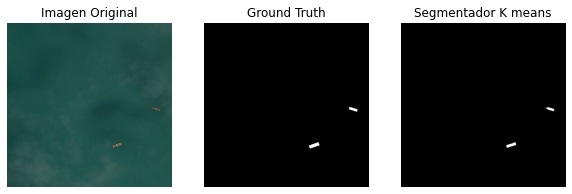

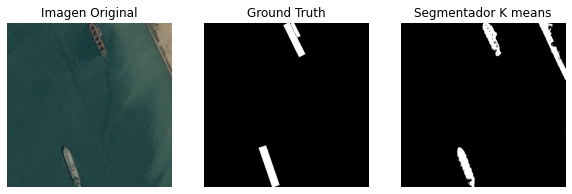

In [ ]:
def apply_kmeans(image, K):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    vectorized = image.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10
    ret,label,center = cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((image.shape))
    return result_image

def kmeans_segmentator(img):
  kmeans = apply_kmeans(img, 10)
  kmeans_gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
  imagen_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kmeans_mask = np.where(kmeans_gray > 70, 0, 255)
  return kmeans_mask/255

image1='ejemplo_2.jpeg'
img1 = io.imread(image1)
image2='ejemplo_1.jpeg'
img2 = io.imread(image2)

kmeans_mask = kmeans_segmentator(img1)
en_pix2 = ['518036 2 518800 6 519565 10 520331 12 521099 12 521868 12 522636 12 523404 12 524172 13 524941 12 525709 12 526477 13 527246 12 528014 12 528782 13 529551 12 530319 12 531087 13 531855 13 532624 12 533392 12 534160 13 534929 12 535697 12 536465 13 537234 12 538002 12 538770 13 539538 13 540307 12 541075 13 541843 13 542612 12 543380 13 544148 13 544917 12 545685 13 546453 13 547221 11 547990 6 548758 2 375359 2 376127 4 376894 8 377662 11 378430 13 379197 16 379965 16 380732 16 381500 16 382268 16 383035 16 383803 16 384571 16 385338 16 386106 16 386874 16 387641 16 388409 16 389176 17 389944 16 390712 16 391479 17 392247 16 393015 16 393782 17 394550 16 395318 16 396085 17 396853 16 397620 17 398388 16 399156 16 399923 17 400691 16 401459 16 402226 17 402994 16 403762 16 404529 17 405297 16 406064 17 406832 17 407600 16 408367 17 409135 17 409905 14 410676 11 411447 8 412217 5 412988 2']
ground_Truth = decodeGroundTruth(en_pix2, img1.shape, image1)
kmeans_mask1 = kmeans_segmentator(img2)
en_pix1 = ['308744 1 309511 4 310279 6 311046 9 311814 11 312581 14 313349 16 314116 19 314884 21 315651 24 316419 26 317186 29 317954 31 318721 34 319489 36 320257 38 321026 39 321796 39 322566 39 323336 39 324106 39 324876 39 325646 39 326416 39 327186 39 327956 39 328726 39 329496 39 330266 39 331036 39 331806 39 332576 39 333346 39 334116 36 334886 34 335656 31 336426 29 337196 26 337966 24 338736 21 339506 19 340276 16 341046 14 341816 11 342586 9 343356 6 344126 4 344896 1 283406 2 284174 4 284941 7 285709 9 286476 12 287244 14 288011 17 288779 19 289546 22 290314 24 291081 27 291849 29 292616 32 293384 34 294151 37 294919 39 295686 42 296454 44 297221 47 297989 49 298756 52 299524 54 300291 57 301059 59 301826 63 302594 65 303361 68 304129 70 304897 72 305665 74 306435 74 307205 74 307975 1 307978 71 308748 71 309518 71 310288 71 311058 71 311828 71 312598 71 313368 71 314138 71 314908 71 315678 71 316448 71 317218 71 317988 71 318758 71 319528 71 320298 71 321068 72 321838 72 322608 72 323378 72 324148 72 324918 72 325688 72 326458 72 327228 72 327998 72 328768 72 329538 72 330308 72 331078 72 331848 72 332617 73 333385 75 334156 74 334926 74 335696 74 336466 74 337236 74 338006 74 338776 74 339546 74 340316 72 341086 69 341856 67 342626 64 343396 62 344166 59 344936 57 345706 54 346476 52 347246 49 348016 47 348786 44 349556 42 350326 39 351096 37 351866 34 352636 32 353406 29 354176 27 354946 24 355716 22 356486 19 357256 17 358026 14 358796 12 359566 9 360336 7 361106 4 361876 2 195657 2 196425 5 197192 9 197960 12 198728 15 199495 18 200263 21 201031 24 201798 28 202566 31 203334 34 204101 38 204869 41 205637 44 206404 48 207172 51 207940 53 208708 56 209475 60 210243 63 211011 66 211778 70 212546 73 213314 76 214081 80 214849 83 215617 85 216384 89 217152 92 217920 95 218687 99 219455 102 220223 105 220990 109 221758 112 222528 113 223299 113 224070 112 224841 112 225612 112 226383 112 227153 113 227924 113 228695 113 229466 113 230237 113 231008 113 231779 113 232550 112 233321 112 234092 112 234863 112 235634 112 236405 112 237175 113 237946 113 238717 113 239488 113 240259 113 241030 113 241801 113 242572 113 243343 113 244114 111 244885 108 245656 105 246427 102 247197 100 247968 97 248739 94 249510 90 250281 87 251052 84 251823 80 252594 77 253365 74 254136 70 254907 67 255678 64 256448 61 257219 58 257990 55 258761 51 259532 48 260303 44 261074 41 261845 38 262616 34 263387 31 264158 28 264929 24 265700 21 266470 19 267241 15 268012 12 268783 9 269554 5 270325 2']
ground_Truth1 = decodeGroundTruth(en_pix1, img2.shape, image2)

def mostrar(imagen, mask1, mask2, titulo_segmentador):
  fig, (ax1,ax2,ax3) = plt.subplots(1,3)
  fig.set_size_inches(10,10)
  ax1.imshow(imagen)
  ax1.set_title("Imagen Original")
  ax1.axis('off')
  ax2.imshow(mask1, cmap='gray')
  ax2.set_title("Ground Truth")
  ax2.axis('off')
  ax3.imshow(mask2, cmap='gray')
  ax3.set_title(titulo_segmentador)
  ax3.axis('off')
  plt.show();

mostrar(img1, ground_Truth, kmeans_mask, "Segmentador K means")
mostrar(img2, ground_Truth1, kmeans_mask1, "Segmentador K means")


Se evalúa el segmentador generado:

In [ ]:
test_segmentator(kmeans_segmentator)

Promedio de las métricas:
TP:  1857.1857142857143  FP:  104277.57142857143 
TN:  480378.9285714286  FN:  3310.3142857142857
Especificidad:  0.8216580200813163  Precision:  0.41391692981282135 Recall:  0.4090340873861649


## Segmentador Canny

El segmentador Canny es un segmentador bastante simple y computacionalmente menos costoso que los otros dos segmentadores propuestos. Inicialmente hace un suavizado de la imagen y, sobre la imagen suavizada, detecta los bordes utilizando Canny. Finalmente, se aplica una dilatación para rellenar los objetos, seguida de una erosión para reducir los contornos.

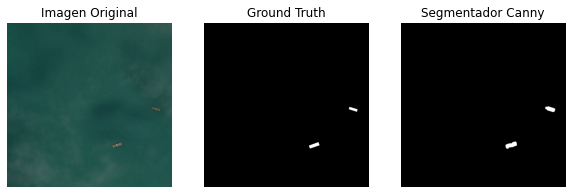

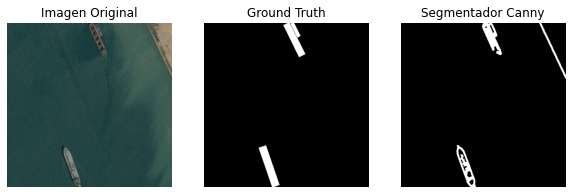

In [ ]:
def canny_segmentator(img):
  blur = cv2.medianBlur(np.array(img, dtype = 'uint8'), 3)
  img1_gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)# Imagen en blanco y negro
  canny = cv2.Canny(img1_gray,60,250)  # Detección de bordes con Canny
  img1_dilat = dilation(canny, disk(6))  # Dilatación
  img1_erod = erosion(img1_dilat, disk(2)) # Erosión 
  return np.where(img1_erod == 0, 0, 255)/255 #Se retorna la máscara

canny_mask = canny_segmentator(img1)
canny_mask2 = canny_segmentator(img2)

mostrar(img1, ground_Truth, canny_mask, "Segmentador Canny")
mostrar(img2, ground_Truth1, canny_mask2, "Segmentador Canny")

Se evalúa el segmentador generado:

In [ ]:
test_segmentator(canny_segmentator)

Promedio de las métricas:
TP:  3834.157142857143  FP:  85466.4 
TN:  499190.1  FN:  1333.3428571428572
Especificidad:  0.853640121980766  Precision:  0.4932145242967803 Recall:  0.7687998514158321


## Segmentador felzenszwalb

Este segmentador produce una sobresegmentación de la imagen usando un rápido y mínimo agrupamiento basado en árboles de expansión. En cuánto a los parámetros de la función, la magnitud de scale determina la configuración de los segmentos, es decir, un valor alto de esta variable implica que el número de segmentos será menor pero estos tendrán un tamaño mayor. Por otro lado, sigma indica el tamaño del kernel Gaussiano que se utiliza para suavizar la imagen de entrada, y min_size determina el tamaño mínimo que pueden alcanzar las regiones. Los valores de estos parámetros se han obtenido de forma empírica, comprobando que se adaptan correctamente a la mayoría de las imágenes escogidas.

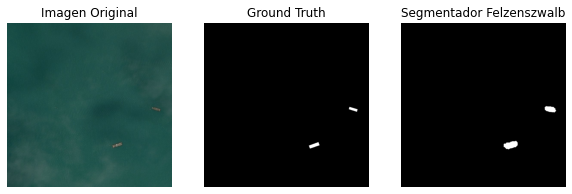

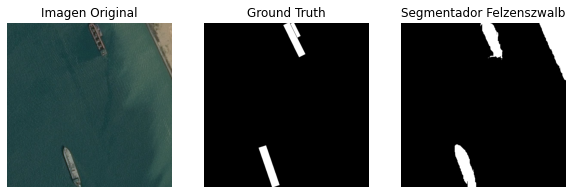

In [ ]:
def felzenszwalb_segmentator(img):
  segments_fz = felzenszwalb(img, scale=400, sigma=4, min_size=400)
  img_fel_1 = color.label2rgb(segments_fz, img, kind='avg', bg_label=0, bg_color=0)
  img_fel_1[img_fel_1 > 0] = 255
  temp = np.where(img_fel_1 == 0, 0, 255)/255
  new = np.zeros((temp.shape[0],temp.shape[1]))
  for i in range(temp.shape[0]): #Se eliminan las capas que no nos interesan
    for j in range(temp.shape[1]):
      new[i][j] = temp[i][j][0]
  return new

felzenszwalb_mask = felzenszwalb_segmentator(img1)
felzenszwalb_mask2 = felzenszwalb_segmentator(img2)

mostrar(img1, ground_Truth, felzenszwalb_mask, "Segmentador Felzenszwalb")
mostrar(img2, ground_Truth1, felzenszwalb_mask2, "Segmentador Felzenszwalb")

Se evalúa el segmentador generado:

In [ ]:
test_segmentator(felzenszwalb_segmentator)

Promedio de las métricas:
TP:  5041.142857142857  FP:  21405.64285714286 
TN:  563250.8571428572  FN:  126.35714285714286
Especificidad:  0.9635313199131909  Precision:  0.4669846752219528 Recall:  0.9678265276759055


## Segmentador Agredado

Este segmentador funciona agregando los resultados de las máscaras binarias obtenidas por otros segmentadores.
El método por el que se realiza esta agregación es por medio de un sistema de vitación en el que hay 3 posibles situaciones:

*   Hay un empate en la votación de los segmentadores y por tanto se elige la selección del mejor
*   Consenso en votación positiva
*   Consenso en votación negativa

Esta agregación genera, como los otros segmentadores, una máscara binaria.



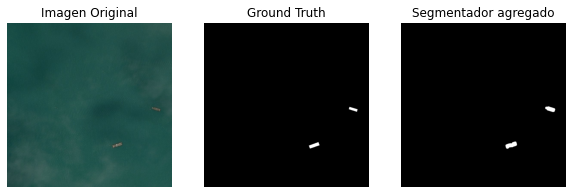

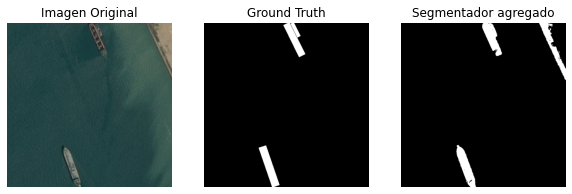

In [ ]:
def segmerter_agregado(image): 
    n, m, dummy = image.shape
    seg1_mask = kmeans_segmentator(image)
    seg2_mask = canny_segmentator(image)
    seg3_mask = felzenszwalb_segmentator(image)
    output = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            mask_sum = seg1_mask[i][j] + seg2_mask[i][j] + seg3_mask[i][j] 
            if  mask_sum == 1.5:
                output[i][j] = seg1_mask[i][j] # Si hay mismo número de barcos que no barcos se selecciona el mejor segmentador
            elif mask_sum < 1.5:
                output[i][j] = 0 # Si hay menos de 2 que seleccionen barco es mar
            else:
                output[i][j] = 1 #Si hay mas de 2 que son barco es barco
    return output

agregado_mask = segmerter_agregado( img1)
agregado_mask2 = segmerter_agregado( img2)
mostrar(img1, ground_Truth, agregado_mask, "Segmentador agregado")
mostrar(img2, ground_Truth1, agregado_mask2, "Segmentador agregado")

Se evalúa el segmentador generado:

In [ ]:
test_segmentator(segmerter_agregado)

Promedio de las métricas:
TP:  4147.1  FP:  65460.0 
TN:  519196.5  FN:  1020.4
Especificidad:  0.8879256033321499  Precision:  0.5472948549210893 Recall:  0.8428666390778291


#Resultados
A continuación se muestran los promedios de las métricas calculadas para los diferentes segmentadores desarrollados:

|               | Kmeans | Canny  | Felzenszwalb | Agregado |
|---------------|--------|--------|--------------|----------|
| Especificidad | 0.8216 | 0.8536 | 0.9635       | 0.8879   |
| Precisión     | 0.4139 | 0.4932 | 0.4669       | 0.5472   |
| Recall        | 0.4090 | 0.7687 | 0.9678       | 0.8428   |

**Si se desea visualizar todas las imágenes del dataset y su resultado se debe modificar la variable "debug" en la función test_segmentador*

# Conclusiones

Como se puede observar el segmentador agregado mejora la precisión a costa de una menor especificidad y Recall que el mejor segmentador obtenido (Felzenszwalb). El agregado se muestra ligeramente más robusto frente a imágenes con mucho ruido, ya sea de nubes o de oleaje.

El hecho de que se hayan usado los mismos parámetros de entrada para todas las imágenes hace que los resultados obtenidos empeoren, pero debido a la complejidad de automatizar la selección de parámetros para cada imágen se ha optado por no implementarlo.

También cabe destacar que el ground truth de este dataset no se ajusta a la silueta de los barcos a identificar, sino que señala el área rectangular donde estos se encuentran, empeorando asi las métricas de los segmentadores puesto que las máscaras generadas si se ajustan a esta silueta.



## 7. Bibliografía


<a id='bib'></a>
<i>[1] 19/02/2021, https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0

<a id='bib'></a>
<i>[2] 19/02/2021, https://www.kaggle.com/c/airbus-ship-detection/overview
